## 1. 数据准备

### 1.1 准备数据集 && 环境配置

In [1]:
!git clone https://github.com/liuyunhaozz/covid19-analysis.git

fatal: destination path 'covid19-analysis' already exists and is not an empty directory.


In [2]:
!pip install matplotlib==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

--2022-09-14 22:48:15--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  48.4MB/s    in 0.2s    

2022-09-14 22:48:15 (48.4 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



### 1.2 导入数据处理中用到的包

In [5]:
import os
import datetime
import json

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from wordcloud import WordCloud

# 用于绘制交互式地图
import plotly.graph_objects as go
import pycountry

# 导入中文字体
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False 




### 1.3 定义通用的函数


In [6]:
"""
确保日期格式符合形如20220101的格式
"""
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y%m%d')
    except ValueError:
        return False
    return True

"""
读取csv文件并对 Dataframe 对象进行预处理，去除不用的columns
返回一个处理过的 DataFrame 对象, 如果读取失败, 返回一个空的Dataframe对象
如果读取国际数据，将isChina置为False，如果读取中国分省数据，将isChina置为True
"""
def read_csv(dir: str, name: str, isChina=False):
    if isChina:
        tag = 'name'
    else:
        tag = 'name_cn'
    try:
        data = pd.read_csv(os.path.join(dir, name + '.csv'))
    except Exception as e:
        print('捕获错误')
        print(e)
        return pd.DataFrame()
    else:
        try:
            final = data.groupby(tag)['累计确诊', '新增确诊', '累计死亡', '新增死亡'].sum().reset_index()
        except Exception as e:
            print('捕获错误: ')
            print(e)
            return pd.DataFrame()
        else:
            return final

"""
读入一个 Dataframe 对象和要获取信息的国家名，返回一个关于该国家信息的 list. 格式为
['国家名', '累计确诊', '新增确诊', '累计死亡', '新增死亡']
"""
def get_country_data(dataframe, name):
    countryData = dataframe.loc[(dataframe['name_cn'] == name)]
    return countryData.values[0]

"""
读入一个 Dataframe 对象和要获取信息的中国行政区名，返回一个有关该行政区信息的 list. 格式为
['行政区名', '累计确诊', '新增确诊', '累计死亡', '新增死亡']
"""
def get_province_data(dataframe, name):
    countryData = dataframe.loc[(dataframe['name'] == name)]
    return countryData.values[0]

"""
读入一个 get_country_data 函数生成的list，返回国家名或中国行政区名
"""
def get_name(info):
    return info[0]

"""
读入一个 get_country_data 函数生成的list，返回累计确诊数
"""
def get_total_confirmed(info):
    return info[1]

"""
读入一个 get_country_data 函数生成的list，返回新增确诊数
"""
def get_new_confirmed(info):
    return info[2]

"""
读入一个 get_country_data 函数生成的list，返回累计死亡数
"""
def get_total_death(info):
    return info[3]

"""
读入一个 get_country_data 函数生成的list，返回新增死亡数
"""
def get_new_death(info):
    return info[4]

## 2. 获取世界各国某天的疫情数据

In [7]:
def generate_country_bar(dir, date, countryName):
    data = read_csv(dir, date)
    countryInfo = get_country_data(data, countryName)
    totalConfirmed = get_total_confirmed(countryInfo)
    newConfirmed = get_new_confirmed(countryInfo)
    totalDeath = get_total_death(countryInfo)
    newDeath = get_new_death(countryInfo)
    infos = ['确诊数', '死亡数', '新增确诊数', '新增死亡数']
    cases = [totalConfirmed, totalDeath, newConfirmed, newDeath]

    title= (countryName + date + u'的疫情数据')
    plt.figure(figsize=(10, 5))

    sns.set(font=zhfont.get_name())
    plt.title(title, fontproperties=zhfont)
    plt.xticks(fontproperties=zhfont)
    fig = sns.barplot(infos, cases)
    
    plt.xlabel(u'信息', fontproperties=zhfont)
    plt.ylabel(u'数量', fontproperties=zhfont)

    # 显示数据标签
    fig.bar_label(fig.containers[0], label_type='edge')

    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


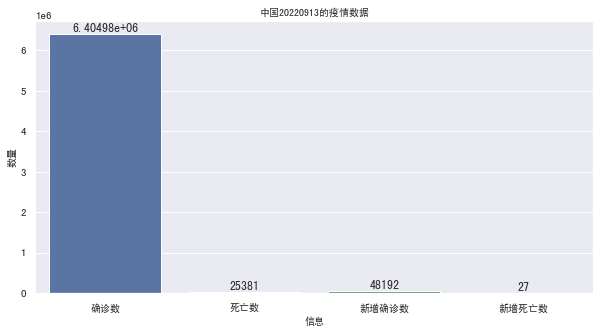

In [8]:
dir = 'covid19-analysis/global'
date = "20220913"
countryName = '中国'

generate_country_bar(dir, date, countryName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


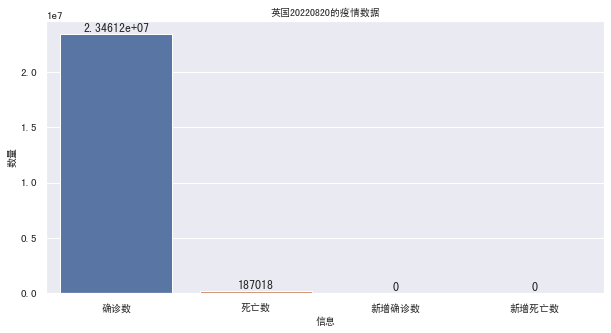

In [9]:
dir = 'covid19-analysis/global'
date = "20220820"
countryName = '英国'

generate_country_bar(dir, date, countryName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


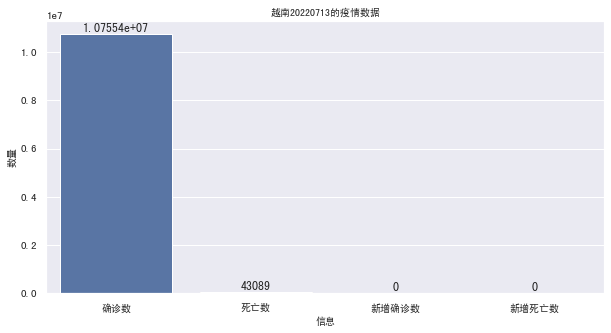

In [10]:
dir = 'covid19-analysis/global'
date = "20220713"
countryName = '越南'

generate_country_bar(dir, date, countryName)

## 3. 获取世界各国的疫情时序增长曲线

In [11]:
def generate_time_curve(dir, startDate, endDate, countryName):
    dates = []
    confirmedCases = []
    deathCases = []
    for date in range(int(startDate), int(endDate) + 1):
        if not validate(str(date)):
            continue
        data = read_csv(dir, str(date))
        if data.empty:
            continue
        countryInfo = get_country_data(data, countryName)
        totalConfirmed = get_total_confirmed(countryInfo)
        totalDeath = get_total_death(countryInfo)
        dates.append(str(date))
        confirmedCases.append(totalConfirmed)
        deathCases.append(totalDeath)

    dates = pd.to_datetime(dates)

    plt.figure(figsize=(10, 5))
    plt.title((countryName + u'的确诊增长曲线'), fontproperties=zhfont)
    sns.set(font=zhfont.get_name())
    plt.xticks(fontproperties=zhfont)
    sns.lineplot(dates, confirmedCases, label=u'确诊数')
    plt.xlabel(u'日期', fontproperties=zhfont)
    plt.ylabel(u'人数', fontproperties=zhfont)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title((countryName + u'的死亡增长曲线'), fontproperties=zhfont)
    sns.set(font=zhfont.get_name())
    plt.xticks(fontproperties=zhfont)
    sns.lineplot(dates, deathCases, label=u'死亡数')
    plt.xlabel(u'日期', fontproperties=zhfont)
    plt.ylabel(u'人数', fontproperties=zhfont)
    plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220723.csv'
捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220724.csv'


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


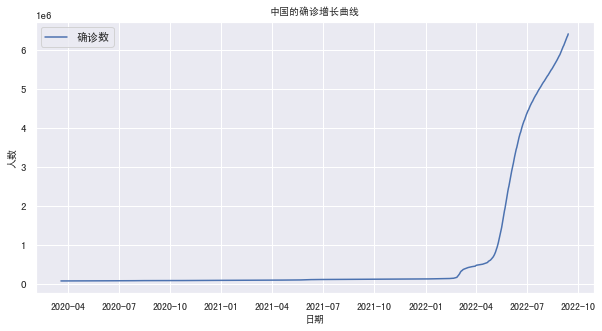

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


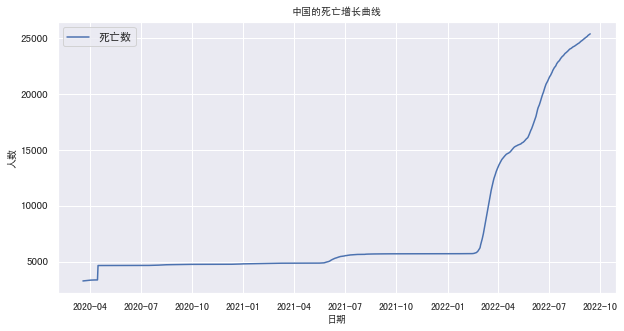

In [12]:
dir = 'covid19-analysis/global'
startDate = "20200320"
endDate = "20220913"
countryName = '中国'

generate_time_curve(dir, startDate, endDate, countryName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220723.csv'
捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220724.csv'


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


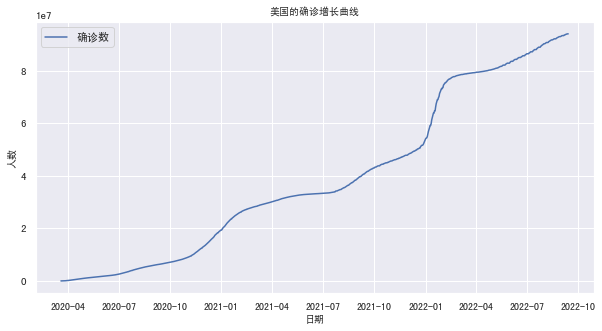

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


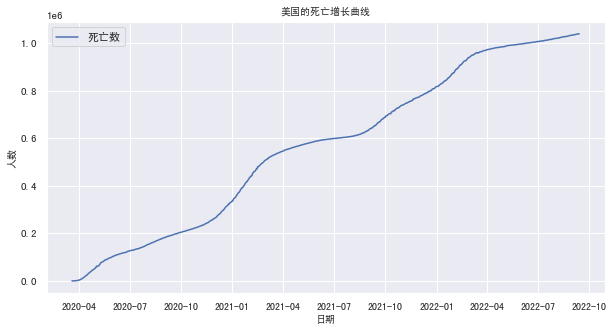

In [13]:
dir = 'covid19-analysis/global'
startDate = "20200320"
endDate = "20220913"
countryName = '美国'

generate_time_curve(dir, startDate, endDate, countryName)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220723.csv'
捕获错误
[Errno 2] No such file or directory: 'covid19-analysis/global/20220724.csv'


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


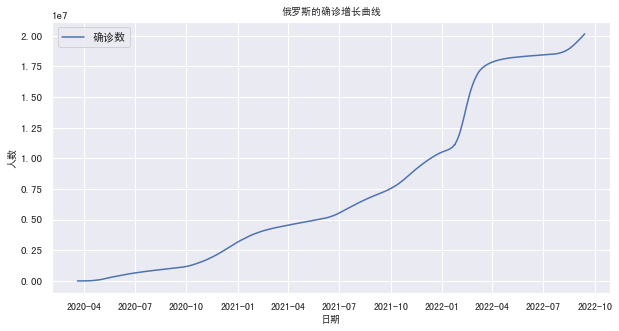

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


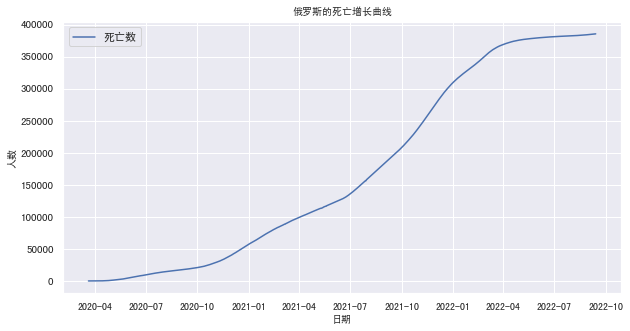

In [14]:
dir = 'covid19-analysis/global'
startDate = "20200320"
endDate = "20220913"
countryName = '俄罗斯'

generate_time_curve(dir, startDate, endDate, countryName)

## 4. 获取某天各国新增确诊数和新增死亡数的词云图

In [15]:
def draw_cloud(date, wordCounts, info):
            # 绘制词云
    confirmedCloud = WordCloud(
        background_color='white',  # 设置背景颜色  默认是black
        width=900, height=600,
        max_words=100,            # 词云显示的最大词语数量
        font_path='simhei.ttf',   # 设置字体  显示中文
        max_font_size=99,         # 设置字体最大值
        min_font_size=16,         # 设置子图最小值
        random_state=50           # 设置随机生成状态，即多少种配色方案
    ).generate_from_frequencies(wordCounts)

    # 显示生成的词云图片
    plt.imshow(confirmedCloud, interpolation='bilinear')

    plt.title((date + u'日' + info + u'数词云图'), fontproperties=zhfont)
    # 显示设置词云图中无坐标轴
    plt.axis('off')
    plt.show()

def generate_newday_wordcloud(dir, date):
    data = read_csv(dir, date)
    confirmedWordCounts = {}
    deathWordCounts = {}
    for index, row in data.iterrows():
        countryInfo = row.values 
        confirmedWordCounts[get_name(countryInfo)] = get_new_confirmed(countryInfo)
        deathWordCounts[get_name(countryInfo)] = get_new_death(countryInfo)
    draw_cloud(date, confirmedWordCounts, u"新增确诊")
    draw_cloud(date, deathWordCounts, u"新增死亡")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


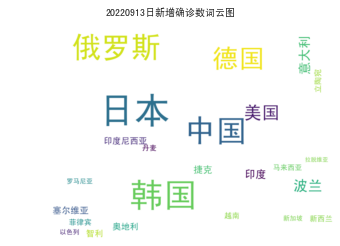

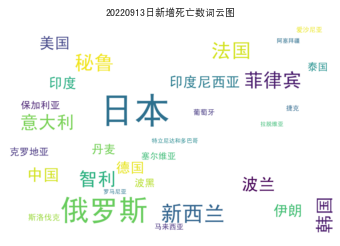

In [16]:
dir = 'covid19-analysis/global'
date = "20220913"

generate_newday_wordcloud(dir, date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


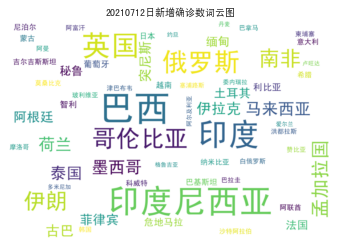

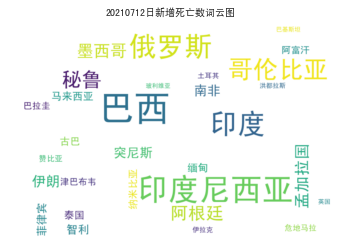

In [17]:
dir = 'covid19-analysis/global'
date = "20210712"

generate_newday_wordcloud(dir, date)

## 创建世界疫情交互式 Choropleth 地图

In [18]:
def generate_worldmap(dir, date):
    # 将中文国家名转为ISO 3166-1三位字母代码
    with open('covid19-analysis/country.json', 'r') as f:
        name2code = json.load(f)
    # print(name2code)
    data = read_csv(dir, date)
    # print(data['name_cn'].unique().tolist())
    list_countries = data['name_cn'].unique().tolist()
    country_code = {}  # To hold the country names and their ISO
    for country in list_countries:
        country_code[country] = name2code[country]

    for name, code in country_code.items():
        data.loc[(data.name_cn == name), 'iso_alpha'] = code


    for col in data.columns:
        data[col] = data[col].astype(str)

    # displaying the details
    data['text'] = data['name_cn'] + '<br>' + \
        '累计确诊: ' + data['累计确诊'] +'<br>'\
        '新增确诊: ' + data['新增确诊'] + '<br>' + \
        '累计死亡: ' +data['累计死亡'] + '<br>' + \
        '新增死亡: ' +data['新增死亡']


    fig = go.Figure(data=go.Choropleth(
        locations = data['iso_alpha'],
        z = data['累计确诊'],
        text = data['text'],
        colorscale = 'Reds',
        autocolorscale=True,
        reversescale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_tickprefix = '',
        colorbar_title = 'No. of Cases',
    ))

    fig.update_layout(
        title_text='COVID 19' + ' in ' + date,
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        ),
        annotations = [dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text='LATEST AS PER DATASET'+'<br>'\
            'Confirmed , newly Confirmed , Death and newly Death Cases'+'<br>'\
            'Analysed by Yunhao Liu',
            showarrow = False
            
        )]
    )

    fig.show()


In [19]:
dir = 'covid19-analysis/global'
date = '20220913'

generate_worldmap(dir, date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [20]:
dir = 'covid19-analysis/global'
date = '20200313'

generate_worldmap(dir, date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## 获取中国截止到某天的累计确诊数最少的五个行政区的确诊人数比例饼图



In [21]:
def draw_pie(date, countsdict):
    sns.set(font=zhfont.get_name())
    province, data = countsdict.keys(), countsdict.values()
    
    fig1, ax1=plt.subplots()
    title= ('中国各行政区截止' + date + u'累计确诊数最少的五个行政区的确诊人数比例')
    plt.title(title, fontproperties=zhfont)
    ax1.pie(data, labels=province , autopct='%1.1f%%',  
            shadow=True, startangle=90, pctdistance=0.9)  
    ax1.axis('equal')  
    plt.show()



def generate_province_data(dir, date):
    
    data = read_csv(dir, date, isChina=True)
    data = data.sort_values(by=['累计确诊']).head(5)

    confirmedCounts = {}

    for index, row in data.iterrows():
        provinceInfo = row.values 
        confirmedCounts[get_name(provinceInfo)] = get_total_confirmed(provinceInfo)

    draw_pie(date, confirmedCounts)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



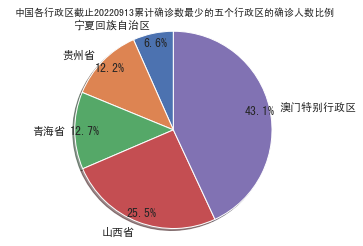

In [22]:
dir = 'covid19-analysis/china'
date = '20220913'

generate_province_data(dir, date)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



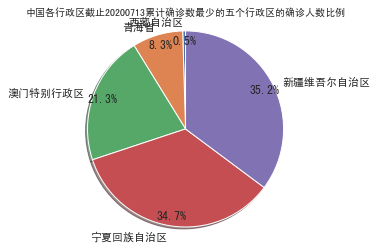

In [23]:
dir = 'covid19-analysis/china'
date = '20200713'

generate_province_data(dir, date)